In [4]:
import copy

import cv2
import numpy as np
import matplotlib.pyplot as plt
# 读入图像并调整大小
img1 = cv2.imread('data/IMG6.jpg')
img2 = cv2.imread('data/IMG5.jpg')
img1 = cv2.resize(img1, dsize=(1024, 512))
img2 = cv2.resize(img2, dsize=(1024, 512))

In [11]:
#   调换颜色通道
def showImage(img):
    img = copy.deepcopy(img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

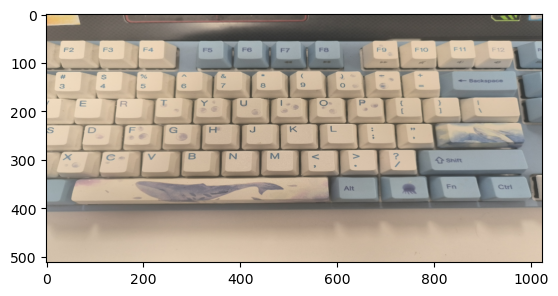

In [12]:
#   展示输入图像
showImage(img1)

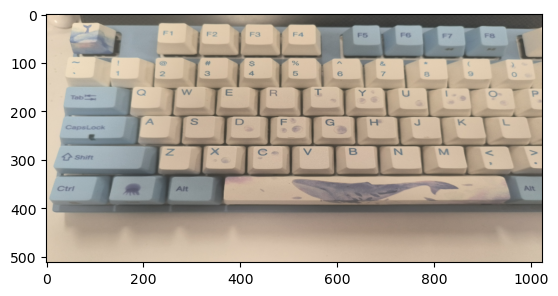

In [13]:
showImage(img2)

In [14]:
# 使用opencv创建SIFT对象
sift = cv2.xfeatures2d.SIFT_create()
# 检测关键点和计算描述符
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

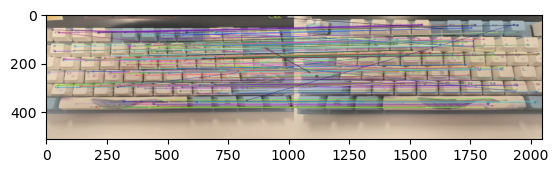

In [15]:
# 匹配关键点
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
# 绘制匹配结果
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)
showImage(img_matches)

In [16]:
#   使用RANSAC算法筛选特征点并得到变换矩阵
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
print(M)

[[ 1.09615903e+00  2.80916121e-02  2.84607011e+02]
 [ 1.00491211e-02  1.07220698e+00 -3.91761098e+01]
 [ 1.08803418e-05 -7.16214218e-05  1.00000000e+00]]


In [17]:
# 计算变换后的四角坐标
def calPoint(H, img):
    height, width = img.shape[:2]
    corners = np.array([[0, 0, 1], [width, 0, 1], [0, height, 1], [width, height, 1]])
    corners_transformed = np.dot(H, corners.T).T
    corners_transformed //= corners_transformed[:, 2].reshape(-1, 1)
    return corners_transformed

corner = calPoint(M, img1)

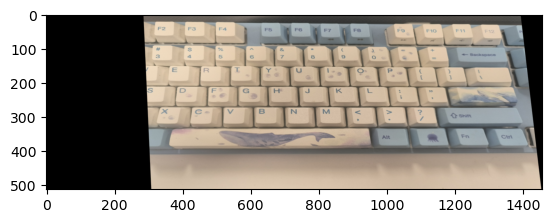

In [18]:
#   做透视性变换
h, w = img1.shape[:2]
img1_warped = cv2.warpPerspective(img1, M, (int(max(corner[1][0], corner[3][0])), img2.shape[0]))
showImage(img1_warped)

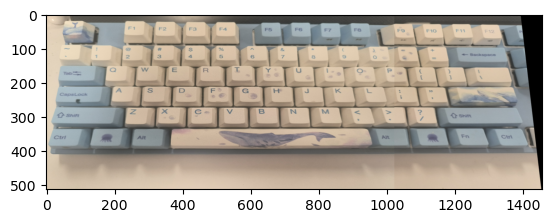

In [19]:
#   直接拼接
img_blend1 = copy.deepcopy(img1_warped)
img_blend1[:img2.shape[0], :img2.shape[1], :] = img2
showImage(img_blend1)

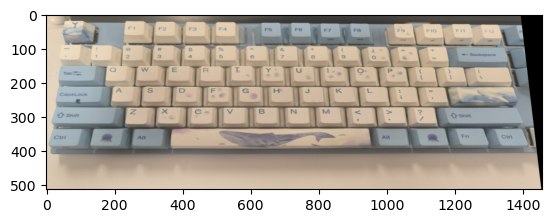

In [20]:
#   使用加权像素方法处理融合区域，权重取决于像素点与区域左边界的距离
def OptimizeSeam(img2, img1warped, img, corner):
    left = int(min(corner[0][0], corner[2][0]))
    right = img2.shape[1]
    width = right - left
    height = img.shape[0]
    for i in range(height):
        for j in range(left, right):
            if sum(img1warped[i, j, :]) == 0:
                alpha = 1.0
            else:
                alpha = (width - (j - left)) / width
            img[i, j, :] = img2[i, j, :] * alpha + img1warped[i, j, :] * (1 - alpha)
    return img
# 计算融合区域
img_blend2 = copy.deepcopy(img_blend1)
left = int(min(corner[0][0], corner[2][0]))
right = img2.shape[1]
height = img_blend2.shape[0]
OptimizeSeam(img2,img1_warped,img_blend2,corner)
showImage(img_blend2)

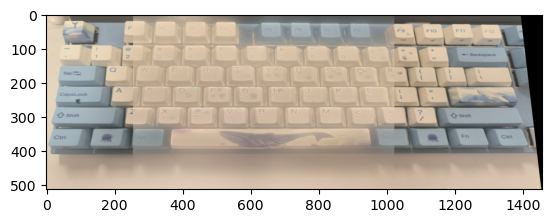

In [21]:
def LP(img_left, img_right, level=6, ratio=0.5):
    G_left = img_left.copy()
    G_right = img_right.copy()
    G_mask = np.zeros(img_left.shape)
    left = int(img_left.shape[1] * ratio)
    G_mask[:, :left] = 1.0
    gp_left = [G_left]
    gp_right = [G_right]
    gp_mask = [G_mask]
    # 生成高斯金字塔
    for i in range(level):
        G_left = cv2.pyrDown(G_left)
        gp_left.append(G_left)
        G_right = cv2.pyrDown(G_right)
        gp_right.append(G_right)
        G_mask = cv2.pyrDown(G_mask)
        gp_mask.append(G_mask)
    # 生成左右图像的拉普拉斯金字塔
    lp_left = [gp_left[level-1]]
    lp_right = [gp_right[level-1]]
    for i in range(level - 1, 0, -1):
        GE_left = cv2.pyrUp(gp_left[i])
        L_left = cv2.subtract(gp_left[i - 1], GE_left)
        lp_left.append(L_left)
        GE_right = cv2.pyrUp(gp_right[i])
        L_right = cv2.subtract(gp_right[i - 1], GE_right)
        lp_right.append(L_right)
    # 融合图像
    gp_mask.pop()
    gp_mask = gp_mask[::-1]
    LS = []
    for l_left, l_mask, l_right in zip(lp_left, gp_mask, lp_right):
        ls = l_mask * l_left + (1 - l_mask) * l_right
        LS.append(ls)
    # 重建图像
    ls_ = LS[0]
    for i in range(1, level):
        ls_ = cv2.pyrUp(ls_)
        ls_ = cv2.add(ls_, LS[i])
    return ls_

img_blend3 = copy.deepcopy(img_blend1)
img_blend3[:height, 256:right, :] = LP(img2[:height, 256:, :], img1_warped[:height, 256:right, :])
showImage(img_blend3)